In [1]:
import itertools
import random
import re

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, models
import transformers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
VOCABULARY = [str(d) for d in range(10)] + ['+', '=', 'Q', 'E', 'F', '!']
VOCABULARY

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '+',
 '=',
 'Q',
 'E',
 'F',
 '!']

In [3]:
def data(n_samples, max_n_digits, seed, min_n_digits=1):
    random.seed(seed)
    already_generated = set()
    
    while True:
        if len(already_generated) >= n_samples:
            break
        
        n_digits = random.randint(min_n_digits, max_n_digits)
        
        a = random.randint(0, 10 ** n_digits - 1)
        b = random.randint(0, 10 ** n_digits - 1)
        
        if (a, b) in already_generated:
            continue
        
        already_generated.add((a, b))
        
        problem = f'{a:0{n_digits}d}+{b:0{n_digits}d}'

        carry = 0
        
        for significance in range(n_digits):
            a_digit = (a // 10 ** significance) % 10
            b_digit = (b // 10 ** significance) % 10
            result = a_digit + b_digit + carry
            result_digit = result % 10
            result_carry = result // 10
            problem += f'Q{carry}+{a_digit}+{b_digit}E{result_carry}{result_digit}'
            carry = result_carry
        
        problem += f'F{a+b}!'
        
        yield problem

next(data(100, 3, 0))

'97+53Q0+7+3E10Q1+9+5E15F150!'

In [4]:
def tokenize(s):
    s = list(s)
    return np.array([VOCABULARY.index(c) for c in s], dtype=np.int32)

def detokenize(arr):
    return ''.join([VOCABULARY[x] for x in arr])

In [5]:
def system_1(s):
    return f'{eval(s):02d}'

system_1('7+1+0')

'08'

In [6]:
def data_generator(dataset):
    for example in dataset:
        idxs = [(m.start(0), m.end(0))
                for m in re.finditer('Q.\+.\+.E|F.*!', example[1:])]
        
        tokens = tokenize(example)
        inputs = tokens[:-1]
        targets = tokens[1:]
        
        mask = np.array([0] * len(targets))
        for s, e in idxs:
            mask[s:e] = 1
        
        yield inputs, targets, mask

In [298]:
class System1Error(Exception):
    pass

def decode_generator(model, a, b):
    n_digits = max(len(str(a)), len(str(b)))
    ex = f"{a:0{n_digits}d}+{b:0{n_digits}d}"
    tokenized = tokenize(ex).astype(np.int32)
    
    while True:
        while not tokenized[-1] in (VOCABULARY.index('E'), VOCABULARY.index('!')):
            pred = model(tokenized[np.newaxis, ...], training=False)
            pred = pred.numpy()
            next_token = np.argmax(pred, axis=-1)[0, -1].astype(np.int32)
            tokenized = np.append(tokenized, next_token)
            yield detokenize(tokenized)

        if tokenized[-1] == VOCABULARY.index('E'):
            # Call system 1
            query = detokenize(tokenized)[-6:-1]
            try:
                ans = system_1(query)
            except Exception as e:
                raise System1Error(e)
            tokenized_ans = tokenize(ans)
            tokenized = np.append(tokenized, tokenized_ans)
            yield detokenize(tokenized)

        elif tokenized[-1] == VOCABULARY.index('!'):
            break

def decode(model, a, b):
    for detokenized in decode_generator(model, a, b):
        pass
    return detokenized

In [299]:
def evaluate(model, test_dataset):
    n_correct = 0
    for example in test_dataset:
        i = example.index('Q')
        ab = example[:i]
        i = ab.index('+')
        a = int(ab[:i])
        b = int(ab[i:])

        try:
            ans = decode(model, a, b)
            i = ans.index('F')
            ans = ans[i+1:-1]
            ans = int(ans)

            if ans == a + b:
                n_correct += 1
        except ValueError as err:
            print("ValueError in eval:", err)
        except System1Error as err:
            print("System1Error in eval:", err)

    return n_correct / len(test_dataset)

In [29]:
def build_model(vocab_size):
    inputs = layers.Input((None,), dtype=tf.int32)
    x = inputs
    x = layers.Embedding(vocab_size, 64)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dense(vocab_size, activation='softmax')(x)
    model = models.Model(inputs, x)
    
    return model

In [30]:
def build_attention_model(vocab_size):
    inputs = layers.Input((None,), dtype=tf.int32)
    x = inputs
    x = layers.Embedding(vocab_size, 64)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    
    # Attention mechanism.
    seq_len = tf.shape(x)[1]
    keys = layers.Dense(128)(x)
    look_ahead_mask = (1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)) * -1e9
    look_ahead_mask = look_ahead_mask[tf.newaxis, ...]
    attention_scores = x @ tf.transpose(keys, [0, 2, 1])
    attention_scores = attention_scores + look_ahead_mask
    attention_weights = tf.nn.softmax(attention_scores, name="attention_weights")
    x_att = attention_weights @ x
    x = layers.Concatenate()([x, x_att])
    
    x = layers.Dense(vocab_size, activation='softmax')(x)
    model = models.Model(inputs, x)
    
    return model

In [300]:
def build_copy_model(vocab_size):
    inputs = layers.Input((None,), dtype=tf.int32)
    x = inputs
    x = layers.Embedding(vocab_size, 64)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    
    batch_size = tf.shape(x)[0]
    seq_len = tf.shape(x)[1]
    keys = layers.Dense(128)(x)
    look_ahead_mask = (1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)) * -1e9
    look_ahead_mask = look_ahead_mask[tf.newaxis, ...]
    attention_scores = x @ tf.transpose(keys, [0, 2, 1])
    attention_scores = attention_scores + look_ahead_mask
    attention_weights = tf.nn.softmax(attention_scores, name="attention_weights")
    x_att = attention_weights @ x
    x_att = layers.Dropout(0.2)(x_att)
    
    # Generative distribution.
    gen_dist = layers.Dense(vocab_size, activation='softmax')(x_att)
    
    # Copy mechanism based distribution.
    indices = tf.range(batch_size, dtype=tf.int32)[:, tf.newaxis]  # (bs, 1)
    indices = tf.tile(indices, [1, seq_len])  # (bs, seq_len)
    indices = tf.stack((indices, inputs), axis=2)
    #indices = tf.transpose(indices, perm=[1, 2, 0])  # (bs, seq_len, 2)
    updates = tf.transpose(attention_weights, perm=[0, 2, 1])
    output_shape = [batch_size, vocab_size, seq_len]
    copy_dist = tf.scatter_nd(indices, updates, output_shape)
    copy_dist = tf.transpose(copy_dist, [0, 2, 1])
    
    # Combine distributions.
    p_gen_pre_logit = layers.Concatenate()([x_att, keys])
    p_gen = layers.Dense(1, activation="sigmoid")(p_gen_pre_logit)
    dist = p_gen * gen_dist + (1 - p_gen) * copy_dist 
    
    model = models.Model(inputs, dist)
    
    return model

In [301]:
def get_model(model_type):
    vocab_size = len(VOCABULARY)
    if model_type == "baseline":
        model = build_model(vocab_size)
    elif model_type == "attention":
        model = build_attention_model(vocab_size)
    elif model_type == "copy":
        model = build_copy_model(vocab_size)
    else:
        raise Exception("Invalid model.")
    model.build(input_shape=(None, None))
    return model

In [304]:
def run_experiment(train_dataset, test_dataset, model):
    tf.keras.backend.clear_session()
    
    batch_size = 64

    train_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(train_dataset),
        output_types=(tf.int32, tf.int32, tf.int32),
        output_shapes=(
            tf.TensorShape((None,)), 
            tf.TensorShape((None,)), 
            tf.TensorShape((None,))
        ))
    train_ds = train_ds.shuffle(10000)
    train_ds = train_ds.padded_batch(batch_size, padded_shapes=([None], [None], [None]))
    train_ds = train_ds.prefetch(100)

    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
    optimizer = optimizers.Adam(1e-3)

    @tf.function
    def train_step(inputs, targets, mask):
        with tf.GradientTape() as tape:
            outputs = model(inputs, training=True)
            loss = tf.losses.sparse_categorical_crossentropy(targets, outputs)
            loss = tf.boolean_mask(loss, tf.cast(mask, tf.bool))
            loss = tf.reduce_mean(loss)

            masked_outputs = tf.boolean_mask(outputs, tf.cast(mask, tf.bool))
            accuracy(targets, outputs, sample_weight=mask)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss

    accuracy_history = []
    stop_criteria_last_n = 5
    
    for i, (inputs, targets, mask) in train_ds.repeat(None).take(4000).enumerate():
        accuracy.reset_states()
        loss = train_step(inputs, targets, mask)
        if i % 100 == 0 and i > 0:
            print(
                'Step', i.numpy(),
                'Loss', loss.numpy(),
                'Acc', accuracy.result().numpy())
            accuracy_history.append(accuracy.result().numpy())
            if len(accuracy_history) > stop_criteria_last_n:
                accuracy_history = accuracy_history[1:]
            if sum(accuracy_history) >= 1.0 * stop_criteria_last_n - 0.000001:
                break
    
    accuracy = evaluate(model, test_dataset)
    
    return accuracy, model

## Baseline

Step 100 Loss 1.1862833 Acc 0.65282214
Step 200 Loss 0.68037593 Acc 0.77059436
Step 300 Loss 0.4845533 Acc 0.8442623
Step 400 Loss 0.29587007 Acc 0.92164946
Step 500 Loss 0.15812694 Acc 0.97021276
Step 600 Loss 0.07327411 Acc 0.99464667
Step 700 Loss 0.037553713 Acc 0.99897116
Step 800 Loss 0.022651564 Acc 1.0
Step 900 Loss 0.01487125 Acc 1.0
Step 1000 Loss 0.009957217 Acc 1.0
Step 1100 Loss 0.0073087015 Acc 1.0
Step 1200 Loss 0.0058434503 Acc 1.0
ValueError in eval: substring not found
System1Error in eval: unexpected EOF while parsing (<string>, line 1)
System1Error in eval: name 'Q0' is not defined
ValueError in eval: invalid literal for int() with base 10: '15F'
ValueError in eval: substring not found
ValueError in eval: invalid literal for int() with base 10: 'F'
ValueError in eval: invalid literal for int() with base 10: 'F3'
System1Error in eval: unexpected EOF while parsing (<string>, line 1)
ValueError in eval: substring not found
System1Error in eval: unexpected EOF while par

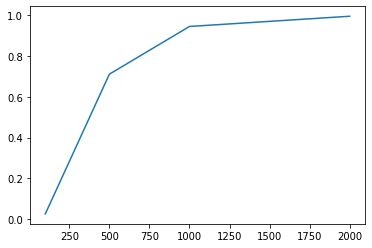

In [34]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [100, 500, 1000, 2000]
accuracies = []

for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    model = get_model(model_type="baseline")
    accuracy, _ = run_experiment(train_dataset, test_dataset, model)
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

In [35]:
accuracies

[0.02666666666666667, 0.71, 0.9433333333333334, 0.9933333333333333]

## Baseline + self attention

Step 100 Loss 1.4945395 Acc 0.6157068
Step 200 Loss 0.71257013 Acc 0.74570817
Step 300 Loss 0.6223441 Acc 0.7964323
Step 400 Loss 0.5438031 Acc 0.8249497
Step 500 Loss 0.38787943 Acc 0.88272923
Step 600 Loss 0.27193817 Acc 0.92142856
Step 700 Loss 0.17974058 Acc 0.9497908
Step 800 Loss 0.20003377 Acc 0.94824016
Step 900 Loss 0.12747312 Acc 0.97308487
Step 1000 Loss 0.0876744 Acc 0.9871106
Step 1100 Loss 0.05597739 Acc 0.9958678
Step 1200 Loss 0.036519613 Acc 0.997921
Step 1300 Loss 0.024524229 Acc 0.9989339
Step 1400 Loss 0.018582297 Acc 1.0
Step 1500 Loss 0.012929136 Acc 1.0
Step 1600 Loss 0.009713276 Acc 1.0
Step 1700 Loss 0.008025642 Acc 1.0
Step 1800 Loss 0.0064589335 Acc 1.0
ValueError in eval: invalid literal for int() with base 10: '1F88'
System1Error in eval: invalid syntax (<string>, line 1)
ValueError in eval: invalid literal for int() with base 10: 'F99'
ValueError in eval: invalid literal for int() with base 10: 'F188'
ValueError in eval: invalid literal for int() with base

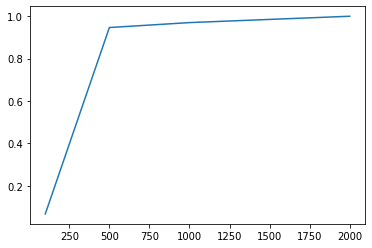

In [39]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [100, 500, 1000, 2000]
accuracies = []
for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    model = get_model(model_type="attention")
    accuracy, _ = run_experiment(train_dataset, test_dataset, model)
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

In [40]:
accuracies

[0.06666666666666667, 0.9466666666666667, 0.97, 1.0]

## Baseline + self attention + copy mechanism

Step 100 Loss 0.38411444 Acc 0.9507042
Step 200 Loss 0.021667484 Acc 1.0
Step 300 Loss 0.0070585534 Acc 1.0
Step 400 Loss 0.0036370384 Acc 1.0
Step 500 Loss 0.0022463168 Acc 1.0
Step 600 Loss 0.001534596 Acc 1.0
Step 100 Loss 0.44649592 Acc 0.92156863
Step 200 Loss 0.016784322 Acc 1.0
Step 300 Loss 0.0058229836 Acc 1.0
Step 400 Loss 0.0029924125 Acc 1.0
Step 500 Loss 0.0018798029 Acc 1.0
Step 600 Loss 0.0013016862 Acc 1.0
Step 100 Loss 0.8320273 Acc 0.7452229
Step 200 Loss 0.08308071 Acc 0.99486655
Step 300 Loss 0.03328858 Acc 0.9979317
Step 400 Loss 0.010380074 Acc 1.0
Step 500 Loss 0.0072118035 Acc 0.9989637
Step 600 Loss 0.003904746 Acc 1.0
Step 700 Loss 0.0027104837 Acc 1.0
Step 800 Loss 0.0019478889 Acc 1.0
Step 900 Loss 0.0015710242 Acc 1.0
Step 1000 Loss 0.0012098234 Acc 1.0
Step 100 Loss 0.6340881 Acc 0.8931841
Step 200 Loss 0.04874879 Acc 0.9989733
Step 300 Loss 0.01375618 Acc 1.0
Step 400 Loss 0.0057922937 Acc 1.0
Step 500 Loss 0.0034799408 Acc 1.0
Step 600 Loss 0.0024150668 

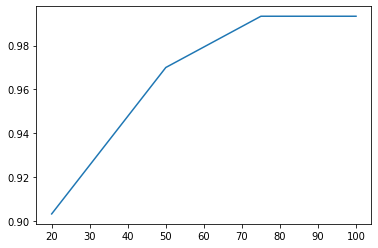

In [36]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [20, 50, 75, 100]
accuracies = []
for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    model = get_model(model_type="copy")
    accuracy, _ = run_experiment(train_dataset, test_dataset, model)
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

In [37]:
accuracies

[0.9033333333333333, 0.97, 0.9933333333333333, 0.9933333333333333]

## Increasing num digits in training data

In [ ]:
train_dataset = data(
    n_samples=20000,
    max_n_digits=10,
    seed=0)
train_dataset = list(train_dataset)

test_dataset = data(
    n_samples=100,
    max_n_digits=11,
    min_n_digits=11,
    seed=0)
test_dataset = list(test_dataset)

accuracy, model = run_experiment(train_dataset, test_dataset, model_type="copy")
print(accuracy)

In [ ]:
decode(model, 11111, 22222)

## Model inspection

In [ ]:
ex = "123+567Q0+3+7E1"
tokenized = tokenize(ex)

model2 = models.Model(
    inputs=model.inputs,
    outputs=[model.outputs, model.get_layer('tf_op_layer_add_1').output])

pred, att_weights = model2(tokenized[np.newaxis, ...])
print("Softmax output:")
print(pred[0][0, -1, :])
print('Argmax token:', VOCABULARY[np.argmax(pred[0][0, -1, :])])

print("Attention weights:")
plt.plot(att_weights[0, -1, :])

[0.89, 0.9966666666666667]

## Increasing num digits in training data

In [ ]:
train_dataset = data(
    n_samples=20000,
    max_n_digits=10,
    seed=0)
train_dataset = list(train_dataset)

test_dataset = data(
    n_samples=100,
    max_n_digits=11,
    min_n_digits=11,
    seed=0)
test_dataset = list(test_dataset)

accuracy, model = run_experiment(train_dataset, test_dataset, model_type="copy")
print(accuracy)

In [ ]:
decode(model, 11111, 22222)

## Curriculum learning

In [303]:
model = get_model(model_type="copy")
for max_n_digits in [8]: #[2,3,4,6,8]:
    train_dataset = data(
        n_samples=10000,
        max_n_digits=max_n_digits,
        seed=0)
    train_dataset = list(train_dataset)

    test_dataset = data(
        n_samples=100,
        max_n_digits=max_n_digits+1,
        min_n_digits=max_n_digits+1,
        seed=0)
    test_dataset = list(test_dataset)

    accuracy, _ = run_experiment(train_dataset, test_dataset, model)
    print("Accuracy with max {} digits, evaluating on {} digits: {}".format(max_n_digits, max_n_digits + 1, 
                                                                            accuracy))

Step 100 Loss 1.7510577 Acc 0.3577692
Step 200 Loss 0.7363128 Acc 0.66133237
Step 300 Loss 0.23070818 Acc 0.93458277
Step 400 Loss 0.16577663 Acc 0.95468163
Step 500 Loss 0.12412925 Acc 0.9715262
Step 600 Loss 0.08000709 Acc 0.97229505
Step 700 Loss 0.058957323 Acc 0.98364484
Step 800 Loss 0.048188433 Acc 0.9865219
Step 900 Loss 0.034118593 Acc 0.99128854
Step 1000 Loss 0.06879918 Acc 0.98642063
Step 1100 Loss 0.04306678 Acc 0.98717946
Step 1200 Loss 0.03255617 Acc 0.9874389
Step 1300 Loss 0.021019923 Acc 0.9956076
Step 1400 Loss 0.026411908 Acc 0.99159354
Step 1500 Loss 0.027465748 Acc 0.98948896
Step 1600 Loss 0.025083784 Acc 0.99016035
Step 1700 Loss 0.02650359 Acc 0.98736006
Step 1800 Loss 0.017496284 Acc 0.99508774
Step 1900 Loss 0.032678075 Acc 0.9862069
Step 2000 Loss 0.028039798 Acc 0.9883063
Step 2100 Loss 0.028856978 Acc 0.98493975
Step 2200 Loss 0.022195157 Acc 0.9897563
Step 2300 Loss 0.034734696 Acc 0.98366606
Step 2400 Loss 0.024519438 Acc 0.9919083
Step 2500 Loss 0.02401

In [47]:
n_correct = 0
for example in test_dataset:
    i = example.index('Q')
    ab = example[:i]
    i = ab.index('+')
    a = int(ab[:i])
    b = int(ab[i:])

    try:
        ans = decode(model, a, b)
        i = ans.index('F')
        ans = ans[i+1:-1]
        ans = int(ans)
        if ans == a + b:
            n_correct += 1
            print(example)
    except ValueError as err:
        print("ValueError in eval:", err)
    except System1Error as err:
        print("System1Error in eval:", err)

097942384+086378036Q0+4+6E10Q1+8+3E12Q1+3+0E04Q0+2+8E10Q1+4+7E12Q1+9+3E13Q1+7+6E14Q1+9+8E18Q1+0+0E01F184320420!


In [135]:
print(decode(model, 123456, 123456))

123456+123456Q0+6+6E12Q1+5+5E11Q1+4+4E09Q0+3+3E06Q0+2+2E04Q0+1+1E02F246912!


## Model inspection

In [112]:
def colorize(chars, alpha):
    return "".join([f"<span style='color: rgba(0, 0, 0, {p * 2/3 + 1/3})'>{char}</span>" 
                    for char, p in zip(chars, alpha)])

In [305]:
decode(model, 123456789, 123456789)

'123456789+123456789Q0+8+9E17Q1+7+7E15Q1+6+6E13Q1+6+6E13!'

In [282]:
model2 = models.Model(
    inputs=model.inputs,
    outputs=[model.outputs, 
             model.get_layer('tf_op_layer_add_1').output, 
             model.get_layer('tf_op_layer_attention_weights').output,
             model.get_layer('dense_2').output,
             model.get_layer('tf_op_layer_transpose_2').output,
             model.get_layer('dense_1').output
            ])

decode_stepper = decode_generator(model, 11111111, 22222222)

Problem:
11111111+22222222Q0+1+2E03Q0+1+2E

Predicted next token: E
p_gen for next token: 1.0
Attention for next token:


<span style='color: rgba(0, 0, 0, 0.3333333333333333)'>1</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>1</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>1</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>1</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>1</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>1</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>1</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>1</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>+</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>2</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>2</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>2</span><span style='color: rgba(0, 0, 0, 0.3333333333333343)'>2</span><span style='color: rgba(0, 0, 0, 0.3333423261434897)'>2</span><span style='color: rgba(0, 0, 0, 0.8630666732788086)'>2</span><span style='color: rgba(0, 0, 0, 0.4702485203742981)'>2</span><span style='color: rgba(0, 0, 0, 0.33334255697870196)'>2</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>Q</span><span style='color: rgba(0, 0, 0, 0.3333333333333337)'>0</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>+</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>1</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>+</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>2</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>E</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>0</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>3</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>Q</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>0</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>+</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>1</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>+</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>2</span><span style='color: rgba(0, 0, 0, 0.3333333333333333)'>E</span>

Historical p_gen


1<span style='color: rgba(0, 0, 0, 0.9999998410542805)'>1</span><span style='color: rgba(0, 0, 0, 1.0)'>1</span><span style='color: rgba(0, 0, 0, 1.0)'>1</span><span style='color: rgba(0, 0, 0, 1.0)'>1</span><span style='color: rgba(0, 0, 0, 1.0)'>1</span><span style='color: rgba(0, 0, 0, 1.0)'>1</span><span style='color: rgba(0, 0, 0, 1.0)'>1</span><span style='color: rgba(0, 0, 0, 1.0)'>+</span><span style='color: rgba(0, 0, 0, 0.9906498988469441)'>2</span><span style='color: rgba(0, 0, 0, 1.0)'>2</span><span style='color: rgba(0, 0, 0, 1.0)'>2</span><span style='color: rgba(0, 0, 0, 1.0)'>2</span><span style='color: rgba(0, 0, 0, 1.0)'>2</span><span style='color: rgba(0, 0, 0, 1.0)'>2</span><span style='color: rgba(0, 0, 0, 1.0)'>2</span><span style='color: rgba(0, 0, 0, 1.0)'>2</span><span style='color: rgba(0, 0, 0, 1.0)'>Q</span><span style='color: rgba(0, 0, 0, 0.9988430738449097)'>0</span><span style='color: rgba(0, 0, 0, 1.0)'>+</span><span style='color: rgba(0, 0, 0, 0.3334324172659156)'>1</span><span style='color: rgba(0, 0, 0, 1.0)'>+</span><span style='color: rgba(0, 0, 0, 0.3333861199110591)'>2</span><span style='color: rgba(0, 0, 0, 1.0)'>E</span><span style='color: rgba(0, 0, 0, 0.9999999205271404)'>0</span><span style='color: rgba(0, 0, 0, 1.0)'>3</span><span style='color: rgba(0, 0, 0, 0.99999205271403)'>Q</span><span style='color: rgba(0, 0, 0, 0.33333333343126825)'>0</span><span style='color: rgba(0, 0, 0, 0.9999970595041912)'>+</span><span style='color: rgba(0, 0, 0, 0.3333333334152246)'>1</span><span style='color: rgba(0, 0, 0, 0.9999994436899822)'>+</span><span style='color: rgba(0, 0, 0, 0.33333336290831284)'>2</span><span style='color: rgba(0, 0, 0, 1.0)'>E</span>

Weighted copy and gen distributions (over vocabulary)


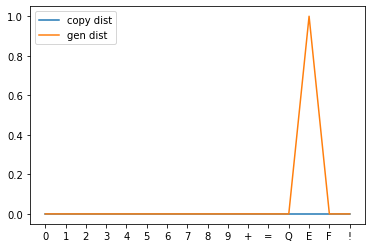

In [297]:
ex = next(decode_stepper)
print("Problem:")
print(ex)

# Tokenize and predict next token
tokenized = tokenize(ex)
pred, output_prob, att_weights, p_gen, copy_dist, gen_dist = model2(tokenized[np.newaxis, ...], training=False)

# Print info about model prediction
print()
print(f"Predicted next token: {VOCABULARY[np.argmax(pred[0][0, -1, :])]}")

last_p_gen = p_gen[0, -1, :][0]
print(f"p_gen for next token: {last_p_gen}")
print("Attention for next token:")
display(Markdown(colorize(ex, att_weights[0, -1, :].numpy())))

print("Historical p_gen")
display(Markdown(ex[0] + colorize(ex[1:], p_gen[0, :-1, 0].numpy())))

print("Weighted copy and gen distributions (over vocabulary)")
plt.figure()
plt.plot(copy_dist[0, -1, :] * (1 - last_p_gen))
plt.plot(gen_dist[0, -1, :] * last_p_gen)
plt.xticks(range(16), VOCABULARY)
_ = plt.legend(["copy dist", "gen dist"])

In [182]:
i = decode_generator(model, 123, 123)

In [178]:
next(i)

'123+123Q0+3+3E06Q0+2+2E'